# Reconstruction of hydrogens from a Berger POPC trajectory and order parameter calculation

In this notebook, we'll show you how to do the complete pipeline from downloading a united-atom trajectory file (Berger POPC) from Zenodo, reconstructing hydrogens and calculating the order parameter using buildH. In addition, we show how to plot the calculated order parameters using matplotlib.


## Foreword


### Launching Unix commands within a Jupyter Notebook

Because buildH is intended to be used in the Unix command line in a terminal, many cells in this notebook will launch Unix commands instead of using standard Python cells. We recall, any cell starting with the symbol `!` will launch a Unix command in the parent shell. For example:

In [1]:
!ls

Berger_POPC_25ns_buildH_calcOP.ipynb


So far, we have only one file (the present notebook) which is shown when Unix command `ls` is launched in a cell.

*Note*: although buildH is usable as a Python module, we show here how to use it using Unix commands which is the standard way.

### Checking buildH installation

First, you have to install buildH. For that you can follow the instructions on the main [README](https://github.com/patrickfuchs/buildH/blob/master/README.md) of the buildH repository. If you did not install buildH, this notebook will not work.

Before launching this notebook, you should have activated the conda environment from buildH (the `$` below corresponds to you prompt) :

```
$ conda activate buildh

```

If this command worked, you should have got the message `(buildh)` 
at the beginning of your prompt stating that the buildh environment has been properly activated. 

Once done, you have launched this Jupyter notebook :

```
$ jupyter lab
```

At this point, we should be able to launch buildH within this notebook:

In [2]:
!buildH

usage: buildH [-h] -c COORD [-t TRAJ] -l LIPID
              [-lt LIPID_TOPOLOGY [LIPID_TOPOLOGY ...]] -d DEFOP
              [-opx OPDBXTC] [-o OUT] [-b BEGIN] [-e END] [-pi PICKLE]
buildH: error: the following arguments are required: -c/--coord, -l/--lipid, -d/--defop


If you do not get this usage message and have some error, you probably did not activate correctly the buildH conda environment before launching this notebook. One other possibility is that the installation of the buildH environment did not succeed. In such a case, please refer to buildH installation.

## Trajectory download

Now, let's download a [trajectory](https://doi.org/10.5281/zenodo.13279) of a Berger POPC membrane from Zenodo (taken from NMRlipidsI project). This should take a while for the trr file, so be patient!

In [3]:
!wget https://zenodo.org/record/13279/files/popc0-25ns.trr
!wget https://zenodo.org/record/13279/files/endCONF.gro
!ls

--2021-04-09 19:11:41--  https://zenodo.org/record/13279/files/popc0-25ns.trr
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1712544744 (1.6G) [application/octet-stream]
Saving to: ‘popc0-25ns.trr’

popc0-25ns.trr      100%[===================>]   1.59G  19.6MB/s    in 94s     

2021-04-09 19:13:16 (17.3 MB/s) - ‘popc0-25ns.trr’ saved [1712544744/1712544744]

--2021-04-09 19:13:16--  https://zenodo.org/record/13279/files/endCONF.gro
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1968406 (1.9M) [application/octet-stream]
Saving to: ‘endCONF.gro’

endCONF.gro         100%[===================>]   1.88M  11.7MB/s    in 0.2s    

2021-04-09 19:13:17 (11.7 MB/s) - ‘endCONF.gro’ saved [1968406/1968406]

Berger_POPC_25ns_buildH_calcOP.ipy

OK the 2 files freshly downloaded are here. Now we need one last file. It's a definition file relating generic names for each C-H bond to the atom names in the PDB file. In buildH, there is a specific directory [def_files](https://github.com/patrickfuchs/buildH/tree/first_notebook/def_files) from which you can download such a def file. (note that you can find some also on the [NMRlipids repo](https://raw.githubusercontent.com/NMRLipids/buildH/master/Berger_POPC_test_case/order_parameter_definitions_MODEL_Berger_POPC.def)). Here we want to download the `.def` file corresponding to POPC Berger (beware that if we want to download it with `wget` from github, we have to add the prefix `raw.` in the URL):

In [4]:
!wget https://raw.githubusercontent.com/patrickfuchs/buildH/master/def_files/order_parameter_definitions_MODEL_Berger_POPC.def
!ls

--2021-04-09 19:13:27--  https://raw.githubusercontent.com/patrickfuchs/buildH/master/def_files/order_parameter_definitions_MODEL_Berger_POPC.def
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2135 (2.1K) [text/plain]
Saving to: ‘order_parameter_definitions_MODEL_Berger_POPC.def’

order_parameter_def 100%[===================>]   2.08K  --.-KB/s    in 0.001s  

2021-04-09 19:13:27 (3.95 MB/s) - ‘order_parameter_definitions_MODEL_Berger_POPC.def’ saved [2135/2135]

Berger_POPC_25ns_buildH_calcOP.ipynb
endCONF.gro
order_parameter_definitions_MODEL_Berger_POPC.def
popc0-25ns.trr


Let's have a look to this def file:

In [5]:
!head order_parameter_definitions_MODEL_Berger_POPC.def

gamma1_1 POPC C1  H11
gamma1_2 POPC C1  H12
gamma1_3 POPC C1  H13
gamma2_1 POPC C2  H21
gamma2_2 POPC C2  H22
gamma2_3 POPC C2  H23
gamma3_1 POPC C3  H31
gamma3_2 POPC C3  H32
gamma3_3 POPC C3  H33
beta1 POPC C5  H51


The first column is the generic C-H name, second is the residue (lipid) name, third column the carbon PDB name, last column the hydrogen PDB name. This file will tell buildH which Hs you want to rebuild, and then to calculate the order parameter on the corresponding C-Hs. It means that it is possible to provide only a subset of possible C-Hs if, for example, you only want those from the polar heads. Note that if you ask buildH to output a trajectory (not done in this notebook), the def file must contain **all** possible C-Hs of the lipid considered.

Now, let's have a quick look to the `.gro` file:

In [6]:
!head endCONF.gro

Generated by trjconv : 2:1:1 sdpc:SM:CHOL system 256 lipids t= 50000.00000
28526
    1PLA     C1    1   5.576   3.681   2.227 -0.0394  0.0935 -0.3339
    1PLA     C2    2   5.553   3.886   2.337  0.1128 -0.0058 -0.1560
    1PLA     C3    3   5.762   3.834   2.277 -0.6144  0.1201 -0.8703
    1PLA     N4    4   5.640   3.768   2.326 -0.1182 -0.1907 -0.0302
    1PLA     C5    5   5.658   3.709   2.460 -0.2986 -0.2323 -0.0245
    1PLA     C6    6   5.766   3.607   2.495  0.4136  0.5471  0.0677
    1PLA     O7    7   5.752   3.488   2.417  0.3142  0.2538  0.5323
    1PLA     P8    8   5.893   3.411   2.413  0.2220  0.1104  0.0738


We see that in this `.gro` file containing POPC lipids, the residue name is called `PLA`. This residue name will be of importance when launching buildH.

Great, all files were successfully downloaded, we can now proceed. Let's launch buildH!

## Launching buildH for order parameter calculation

Now, we can launch buildH on this downloaded trajectory. For that we need a few arguments :

- the `-c` argument corresponding to the coordinate file. It consists of a pdb or gro file, here `endCONF.gro`, buildH infers the topology of the system from it;
- the `-l` argument which tells which lipid we want to analyze, here `Berger_PLA` (`Berger` corresponds to the force field name used for this simulation, `PLA` is the residue name of the lipid we want to analyze in the topfile); note that if you simulated a mixture of different lipids, you will have to launch buildH separately for each lipid;
- the `-d` argument corresponding to the def file we just downloaded, here `order_parameter_definitions_MODEL_Berger_POPC.def` ;
- the `-t` argument which is the trajectory file, here `popc0-25ns.trr`.
- the `-o` argument which tells buildH the output file name for storing the calculated order parameters.

Please be patient, this will take a while since we have 2500 frames (you have time for a coffee ;-) ). On single core Xeon @ 3.60GHz, it took ~ 35'.

In [9]:
!buildH -c endCONF.gro -l Berger_PLA -d order_parameter_definitions_MODEL_Berger_POPC.def \
    -t popc0-25ns.trr -o OP_POPC_Berger_25ns.out

Constructing the system...
System has 28526 atoms
Dealing with frame 0 at 0.0 ps.
Dealing with frame 1 at 10.0 ps.
Dealing with frame 2 at 20.0 ps.
Dealing with frame 3 at 30.0 ps.
Dealing with frame 4 at 40.0 ps.
Dealing with frame 5 at 50.0 ps.
^C
Traceback (most recent call last):
  File "/home/fuchs/software/miniconda3/envs/buildh/bin/buildH", line 33, in <module>
    sys.exit(load_entry_point('buildh', 'console_scripts', 'buildH')())
  File "/home/fuchs/papers/buildH_Amelie/buildH/buildh/cli.py", line 208, in main
    core.fast_build_all_Hs_calc_OP(universe_woH, begin, end, dic_OP,
  File "/home/fuchs/papers/buildH_Amelie/buildH/buildh/core.py", line 548, in fast_build_all_Hs_calc_OP
    op = geo.calc_OP(Cname_position, H_coor)
  File "/home/fuchs/papers/buildH_Amelie/buildH/buildh/geometry.py", line 195, in calc_OP
    vec = H - C
KeyboardInterrupt


On the above cell, I launched buildH to show you how it works. For each frame handled by buildH, a message `Dealing with frame XXX at YYY ps.` is printed to the output. Because it takes some time and because it should have printed 2500 `Dealing with frame...`, I just pressed Ctrl-C to get this notebook not too much polluted by buildH output. This explains why there is a Python `KeyboardInterrupt`.

Note that, you can also launch buildH in a regular shell that way:

```
$ buildH -c endCONF.gro -l Berger_PLA -d order_parameter_definitions_MODEL_Berger_POPC.def \
    -t popc0-25ns.trr -o OP_POPC_Berger_25ns.out
```

Or that way:

```
$ buildH -c endCONF.gro -l Berger_PLA -d order_parameter_definitions_MODEL_Berger_POPC.def \
    -t popc0-25ns.trr -o OP_POPC_Berger_25ns.out > /dev/null
```

In this case, all the messages `Dealing with frame...` go to `/dev/null`, thus no more pollution ;-).

Once completed, we should have a new file called `OP_POPC_Berger_25ns.out` containing the order parameters. You can choose any name with the option `-o` when you launch buildH.

In [10]:
!ls

Berger_POPC_25ns_buildH_calcOP.ipynb
endCONF.gro
OP_POPC_Berger_25ns.out
order_parameter_definitions_MODEL_Berger_POPC.def
popc0-25ns.trr


## Analyzing results

First, let's have a look to what this output file `OP_POPC_Berger_25ns.out` contains.

In [11]:
!head OP_POPC_Berger_25ns.out

# OP_name            resname atom1 atom2  OP_mean OP_stddev OP_stem
#--------------------------------------------------------------------
gamma1_1             PLA     C1    H11    0.01788  0.09262  0.00819
gamma1_2             PLA     C1    H12   -0.00744  0.03963  0.00350
gamma1_3             PLA     C1    H13   -0.00855  0.03601  0.00318
gamma2_1             PLA     C2    H21    0.01850  0.09283  0.00820
gamma2_2             PLA     C2    H22   -0.00666  0.04559  0.00403
gamma2_3             PLA     C2    H23   -0.00894  0.04016  0.00355
gamma3_1             PLA     C3    H31    0.01854  0.09235  0.00816
gamma3_2             PLA     C3    H32   -0.01158  0.03796  0.00335


For each C-H we get the mean order parameter (OP_mean averaged over frames and over residues), its standard deviation (OP_stddev again over frames and over residues), and its standard error of the mean (OP_stem). This OP_stem is calculated in the following way:

$$OP_{stem}(CH) = \frac{ \frac{1}{N} \sum_{i=1}^{N} OP(CH)_i }{\sqrt{N}}$$

where *N* is the number of lipids, $OP(CH)_i$ is the mean order parameter of a given CH of residue $i$ (this $OP(CH)_i$ is itself an average of the order parameter of a given CH of residue *i* over frames). In fact, we first average over frames, then we average over residues to compute the STEM.

Now we can make a plot of the order parameter. For that, we can use Pandas and its very convenient dataframes to load buildH output. Pandas dataframes allow the selection of any row or column in a very powerfull way. If you are not familiar with pandas dataframes, you can take a look [here](https://realpython.com/pandas-dataframe/). For reading buildH output and generate a dataframe, we use the Pandas function `.read_csv()` which has a great deal of options to read a file. Here we tell it to use a specific separator (`\s+` which means any combination of white spaces), to skip 2 lines at the beginning of the files (beginning with a `#`) and to assign specific names to each column.

In [12]:
import pandas as pd

df = pd.read_csv("OP_POPC_Berger_25ns.out", sep="\s+", skiprows=2, 
                 names=["CH_name", "res", "carbon", "hydrogen", "OP", "STD", "STEM"])
df

,CH_name,res,carbon,hydrogen,OP,STD,STEM
0,gamma1_1,PLA,C1,H11,0.01788,0.09262,0.00819
1,gamma1_2,PLA,C1,H12,-0.00744,0.03963,0.00350
2,gamma1_3,PLA,C1,H13,-0.00855,0.03601,0.00318
3,gamma2_1,PLA,C2,H21,0.01850,0.09283,0.00820
4,gamma2_2,PLA,C2,H22,-0.00666,0.04559,0.00403
...,...,...,...,...,...,...,...
77,oleoyl_C17a,PLA,CA1,HA11,-0.05500,0.01999,0.00177
78,oleoyl_C17b,PLA,CA1,HA12,-0.05225,0.01950,0.00172
79,oleoyl_C18a,PLA,CA2,HA21,0.03903,0.02647,0.00234
80,oleoyl_C18b,PLA,CA2,HA22,-0.05292,0.02033,0.00180


If we want only the order parameter for the polar head we can use the following. Suffixing the dataframe with a list of list `[["CH_name", "OP"]]` allow us to select the columns we are interested in. Then, with the `.iloc()` method we can get the 18 first rows corresponding to the polar head (beware it starts counting at 0 like all sequential objects in Python).

In [13]:
df[["CH_name", "OP"]].iloc[:18]

,CH_name,OP
0,gamma1_1,0.01788
1,gamma1_2,-0.00744
2,gamma1_3,-0.00855
3,gamma2_1,0.01850
4,gamma2_2,-0.00666
5,gamma2_3,-0.00894
6,gamma3_1,0.01854
7,gamma3_2,-0.01158
8,gamma3_3,-0.00715
9,beta1,0.03634


Let's do the same for the palmitoyl chain.

In [14]:
df[["CH_name", "OP"]].iloc[18:49]

,CH_name,OP
18,palmitoyl_C2a,-0.17593
19,palmitoyl_C2b,-0.16136
20,palmitoyl_C3a,-0.19742
21,palmitoyl_C3b,-0.18853
22,palmitoyl_C4a,-0.19367
23,palmitoyl_C4b,-0.18011
24,palmitoyl_C5a,-0.19815
25,palmitoyl_C5b,-0.19364
26,palmitoyl_C6a,-0.19251
27,palmitoyl_C6b,-0.19193


And now, for the oleoyl chain.

In [15]:
df[["CH_name", "OP"]].iloc[49:]

,CH_name,OP
49,oleoyl_C2a,-0.15474
50,oleoyl_C2b,-0.17336
51,oleoyl_C3a,-0.16911
52,oleoyl_C3b,-0.17847
53,oleoyl_C4a,-0.17385
54,oleoyl_C4b,-0.18235
55,oleoyl_C5a,-0.17504
56,oleoyl_C5b,-0.17690
57,oleoyl_C6a,-0.16138
58,oleoyl_C6b,-0.16692


## Plot of the order parameter

Now that we have loaded the data with pandas, and that we can select any part of the lipid, we can use the matplotlib module to make a nice plot. For example, we can plot the order parameter of the palmitoyl chain. Note that we select rows 18 to 45 to show only the first 15 carbons, since we do not want the final CH3 of carbon 16.

Text(0.5, 1.0, 'Order parameter palmitoyl chain, Berger POPC')

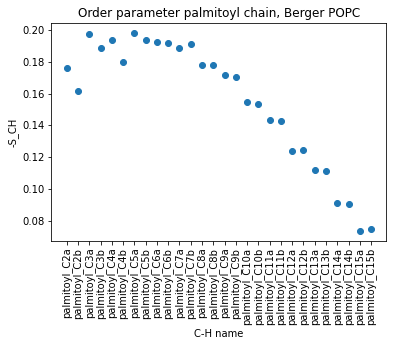

In [16]:
import numpy as np
import matplotlib.pyplot as plt

OPs = df["OP"].iloc[18:46]

x = np.arange(len(OPs))
plt.scatter(x, -OPs)
plt.xticks(x, df["CH_name"].iloc[18:46], rotation='vertical')
plt.xlabel("C-H name")
plt.ylabel("-S_CH")
plt.title("Order parameter palmitoyl chain, Berger POPC")

Another example with the polar head, on the alpha beta of the choline and glycerol C-Hs.

Text(0.5, 1.0, 'Order parameter polar head, Berger POPC')

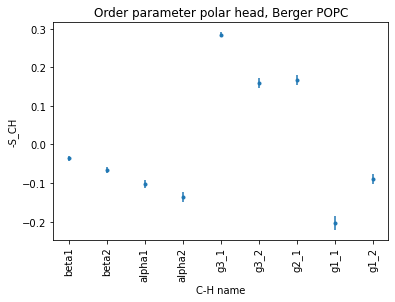

In [17]:
import numpy as np
import matplotlib.pyplot as plt

OPs = df["OP"].iloc[9:18]
STEMs = df["STEM"].iloc[9:18]

# These 2 avoid plotting a line between the points.
lines = {'linestyle': 'None'}
plt.rc('lines', **lines)

x = np.arange(len(OPs))
plt.errorbar(x, -OPs, STEMs, fmt='', marker='.')
plt.xticks(x, df["CH_name"].iloc[9:18], rotation='vertical')
plt.xlabel("C-H name")
plt.ylabel("-S_CH")
plt.title("Order parameter polar head, Berger POPC")

Since the error bars are very small, I used `marker='.'` to draw tiny points. If we use the standard `marker='o'`, the error bars are often not seen because they are smaller than the point itself.

## Conclusion

In this notebook, we showed you how to use buildH to build hydrogens from a united-atom trajectory and calculate the order parameter on it. Then, we showed some convenient use of pandas and matplotlib Python modules to select the data we are interested in and plot the corresponding results.